In [1]:
import pickle
import copy
import numpy as NP
# from scipy.spatial import KDTree
import scipy as SP
# from scipy import sparse
from astropy.io import ascii
from astropy import units as U
from astropy import constants as FC
# from astroutils import lookup_operations as LKP
# from astroutils import gridding_modules as GRD
import matplotlib as MPL
import matplotlib.pyplot as PLT
import matplotlib.colors as PLTC
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from IPython.core.debugger import set_trace

In [2]:
def ix_to_unraveled_ind(ixlist):
    ind_list = [(NP.repeat(ix_[0], ix_[1].size, axis=1).ravel(), NP.repeat(ix_[1], ix_[0].size, axis=0).ravel()) for ix_ in ixlist]
    return ind_list

def unraveled_to_raveled(unraveled_ind_list, shape):
    ind_list = [NP.ravel_multi_index(ind, shape) for ind in unraveled_ind_list]
    return ind_list

def rect2DNN_to_ix_(ycornerNN, xcornerNN, ysizeNN, xsizeNN):
    ycornerNN = NP.array(ycornerNN)
    xcornerNN = NP.array(xcornerNN)
    ysizeNN = NP.array(ysizeNN)
    xsizeNN = NP.array(xsizeNN)
    ix_ = [NP.ix_(ycornerNN[i]+NP.arange(ysizeNN[i]), xcornerNN[i]+NP.arange(xsizeNN[i])) if xsizeNN[i]*ysizeNN[i] > 0 else NP.ix_([], []) for i in range(len(xcornerNN))]
    return ix_

def rect2DNN(x_ngbrof, y_ngbrof, x_ngbrin, y_ngbrin, delX=1, delY=1):
    dx = x_ngbrin[1] - x_ngbrin[0]
    dy = y_ngbrin[1] - y_ngbrin[0]
    delX_fltind = delX / dx
    delY_fltind = delY / dy
    x_ngbrof_fltind = (x_ngbrof - x_ngbrin.min()) / dx
    y_ngbrof_fltind = (y_ngbrof - y_ngbrin.min()) / dy
    delX_rounded = NP.round(delX_fltind).astype(int)
    delY_rounded = NP.round(delY_fltind).astype(int)
    xsizeNN = NP.clip(delX_rounded, 1, None).astype(int)
    ysizeNN = NP.clip(delY_rounded, 1, None).astype(int)
    xcornerNN = NP.round(x_ngbrof_fltind).astype(int) - xsizeNN//2
    ycornerNN = NP.round(y_ngbrof_fltind).astype(int) - ysizeNN//2
    n_oob_xleft = NP.clip(-xcornerNN, 0, None).astype(int)
    n_oob_xright = NP.clip(xcornerNN-(x_ngbrin.size-1), 0, None).astype(int)
    n_oob_yleft = NP.clip(-ycornerNN, 0, None).astype(int)
    n_oob_yright = NP.clip(ycornerNN-(y_ngbrin.size-1), 0, None).astype(int)
    xsizeNN -= (n_oob_xleft + n_oob_xright)
    ysizeNN -= (n_oob_yleft + n_oob_yright)
    areaNN = NP.array(xsizeNN) * NP.array(ysizeNN)
    xcornerNN = NP.clip(xcornerNN, 0, x_ngbrin.size-1).astype(int)
    ycornerNN = NP.clip(ycornerNN, 0, y_ngbrin.size-1).astype(int)
    return (xcornerNN, ycornerNN, xsizeNN, ysizeNN, areaNN)


In [3]:
def grid(rangelist, pad=None, spacing=None, pow2=True, verbose=True):

    """
    -----------------------------------------------------------------------------
    Produce a multi-dimensional grid.
    
    Inputs:
    rangelist [list of tuples] Each tuple is made of two elements, the min and
              max with min < max. One tuple for each axis.
             
    pad       [Optional. Scalar or list] The padding (in same units as range) to
              be applied along the axes. Default=None implies no padding.
              
    spacing   [Optional. Scalar or list] The spacing for the grid along each of
              the axes. If not supplied, a default of sqrt(max-min) is used. If a
              scalar is supplied, it applies for all axes. A list applies for
              each of the axes.
              
    pow2      [Optional, default=True] If set, the grid produced is a power of 2
              in all axes, which is useful for FFT.
              
    verbose   [Default=True]

    Outputs:

    tupleout  [List of tuples] A 4-element tuple for each axis. The elements in
              each tuple are min, max, lengths, and spacing (which could have
              been modified relative to input). The precise grid points can be
              generated by using numpy's linspace using min, max and lengths.
    -----------------------------------------------------------------------------
    """

    for item in rangelist:
        if item[0] >= item[1]:
            raise ValueError('Data ranges provided not compatible with min < max. Exiting from grid().')

    if pad is None:
        pad = NP.zeros(len(rangelist))
    elif isinstance(pad, (int,float)):
        pad = [pad]
    elif isinstance(pad, NP.ndarray):
        pad = pad.tolist()
    elif not isinstance(pad, list):
        raise TypeError('pad must be set to None, scalar, list or numpy array')
        
    if len(pad) == 1:
        pad = [pad] * len(rangelist)
    elif len(pad) > len(rangelist):
        pad = NP.asarray(pad[:len(rangelist)])
    elif (len(pad) > 1) and (len(pad) < len(rangelist)):
        if verbose is True:
            print('Insufficient paddings provided compared to the number of data ranges.')
            print('Assuming the remaining paddings to be zero.')
        pad += [0.0 for ranges in rangelist[len(pad):]]
    # pad = NP.reshape(NP.asarray(pad).reshape(1,-1),len(pad)) # Force it to be row vector
    pad = NP.asarray(pad).flatten()
    pad.clip(min(NP.abs(pad))) # Remove any negative values for pad

    if spacing is None:
        if verbose is True:
            print('No spacing provided. Setting defaults to sqrt(max-min)')
            print('Final spacings could be different from defaults assumed.')
        spacing = [NP.sqrt(rangelist[i][1]-rangelist[i][0]+2*pad[i]) for i in range(len(rangelist))]
    elif isinstance(spacing, (int, float)):
        if verbose is True:
            print('Scalar value for spacing provided. Assuming spacing is identical along all axes.')
        spacing = [spacing] * len(rangelist)
    elif len(spacing) > len(rangelist):
        if verbose is True:
            print('Too many values of spacing provided. Ignoring values for indices beyond the length of data ranges.')
        spacing = NP.asarray(spacing[:len(rangelist)])
    elif (len(spacing) > 1) and (len(spacing) < len(rangelist)):
        if verbose is True:
            print('Insufficient spacings provided compared to the number of data ranges.')
            print('Assuming the remaining spacings to be default spacing.')
            print('Final spacings could be different from defaults assumed.')
        # spacing += [NP.sqrt(ranges[1]-ranges[0]) for ranges in rangelist[len(spacing):]]
        spacing += [NP.sqrt(rangelist[i][1]-rangelist[i][0]+2*pad[i]) for i in range(len(spacing),len(rangelist))]
    # spacing = NP.asarray(spacing).reshape(1,-1) 
    spacing = NP.asarray(spacing).flatten()
    spacing.clip(min(NP.abs(spacing)))

    rangelist = NP.asarray(rangelist)
    lengths = NP.ceil((rangelist[:,1]-rangelist[:,0]+2*pad)/spacing)+1
    lengths = lengths.astype(int)

    for i in range(len(lengths)): 
        if (lengths[i] % 2) == 0: lengths[i] += 1
        # make it odd number of bin edges enclsoing first
        # and last intervals so that the mid-point is one
        # of the bin edges.

    if pow2 is True:
        lengths = 2**NP.ceil(NP.log2(lengths))
        lengths = lengths.astype(int)
        newspacing = (rangelist[:,1]-rangelist[:,0]+2*pad)/(lengths-2)
        offsets = rangelist[:,0]-pad+(lengths-2)*newspacing - (rangelist[:,1]+pad)
        tupleout = list(zip(rangelist[:,0]-pad-0.5*offsets-newspacing, rangelist[:,1]+pad+0.5*offsets, lengths, newspacing)) # converts numpy arrays into a list of tuples
        # tupleout = tuple(map(tuple, NP.column_stack((rangelist[:,0]-pad-0.5*offsets-newspacing, rangelist[:,1]+pad+0.5*offsets, lengths, newspacing)))) # converts numpy arrays into a list of tuples
    else:
        offsets = rangelist[:,0]-pad+(lengths-1)*spacing - (rangelist[:,1]+pad)
        tupleout = list(zip(rangelist[:,0]-pad-0.5*offsets, rangelist[:,1]+pad+0.5*offsets, lengths, spacing)) # converts numpy arrays into a list of tuples
        # tupleout = tuple(map(tuple, NP.column_stack((rangelist[:,0]-pad-0.5*offsets, rangelist[:,1]+pad+0.5*offsets, lengths, spacing)))) # converts numpy arrays into a list of tuples
    
    return tupleout

In [4]:
def gen_ant_grid_wts_cube(vusize, raveled_ind_lol, ant_grid_wts_lol):
    nchan = len(raveled_ind_lol)
    npol = 2
    outarr = NP.zeros((nchan,npol,npol,vusize), dtype=complex) # (nchan,npol,npol,nvusize)
    for iwl in range(nchan):
        for ravind, awts in zip(raveled_ind_lol[iwl], ant_grid_wts_lol[iwl]):
            ixind = NP.ix_([iwl], NP.arange(npol), NP.arange(npol), ravind)
            outarr[ixind] += awts[NP.newaxis,...] # (1,npol,npol,npix)
    return outarr

def gen_grid_Ef_cube(vusize, raveled_ind_lol, grid_Ef_chan_list):
    nchan = len(raveled_ind_lol)
    nruns = grid_Ef_chan_list[0].shape[0]
    nant = len(raveled_ind_lol[0])
    npol = 2
    outunit = grid_Ef_chan_list[0].unit
    outarr = NP.zeros((nruns,nchan,npol,vusize), dtype=complex) * outunit # (nruns, nchan, npol, nvusize)
    for iwl in range(nchan):
        for ii,ravind in enumerate(raveled_ind_lol[iwl]):
            ixind = NP.ix_(NP.arange(nruns), [iwl], NP.arange(npol), ravind)
            outarr[ixind] += grid_Ef_chan_list[iwl][:,ii,:,:][:,NP.newaxis,...] # (nruns,1,npol,npix)
    return outarr

def gen_image(inparr, fftshape=None, fftaxes=(-2,-1), polaxis=-4, freqaxis=-3, bwsyn=False):
    polaxis = (polaxis+inparr.ndim) % inparr.ndim
    freqaxis = (freqaxis+inparr.ndim) % inparr.ndim
    outarr = SP.fft.fft2(inparr, s=fftshape, axes=fftaxes)
    outarr = NP.expand_dims(outarr, axis=polaxis) * NP.expand_dims(outarr, axis=polaxis+1).conj()
    if bwsyn:
        outarr = NP.sum(outarr, axis=freqaxis, keepdims=True)
    outarr = SP.fft.fftshift(outarr, axes=fftaxes)
    return outarr

In [5]:
datadir = '/mnt/data/users/thy009/projects/multi-scale-imaging-architectures/data/'
antwtsfile = 'epic-test-ant-wts-32x32-grid-256-ants-10-chans.pkl'
datafile = 'epic-test-data-10000-runs-32x32-grid-256-ants-10-chans.npz'

In [24]:
data = NP.load(datadir+datafile)
antpos = data['antpos'] * U.m
freqs = data['freqs'] * U.MHz
xcornerNN = data['xcorners']
ycornerNN = data['ycorners']
xsizeNN = data['xsizes']
ysizeNN = data['ysizes']
ant_Etafp = data['ant_Etafp'] * U.Jy**(1/2)
nants = antpos.shape[0]
nchan = freqs.size
df = freqs[1] - freqs[0]
bw = df * nchan 
wl = FC.c / freqs
delT = (1/df).to(U.s)
dt = (1/bw).to(U.s)
nruns = ant_Etafp.shape[0]
duration = nruns * delT 
times = NP.arange(nruns) * delT

In [7]:
antx, anty, antz = antpos.T
au = antx.reshape(-1,1) / wl.reshape(1,-1)
av = anty.reshape(-1,1) / wl.reshape(1,-1)
aw = antz.reshape(-1,1) / wl.reshape(1,-1)
au_min = au.min()
av_min = av.min()
aw_min = aw.min()
au_max = au.max()
av_max = av.max()
aw_max = aw.max()

In [8]:
sizex_ant = 2.0 * U.m
sizey_ant = 2.0 * U.m 
upad = sizex_ant / wl.min()
vpad = sizey_ant / wl.min()
du_ant = sizex_ant / wl.max()
dv_ant = sizey_ant / wl.max()
ant_uvec_info, ant_vvec_info = grid([(au_min,au_max), (av_min,av_max)], pad=[upad, vpad], spacing=[du_ant, dv_ant], pow2=True)
ant_uvec = NP.linspace(ant_uvec_info[0], ant_uvec_info[1], num=ant_uvec_info[2], endpoint=True)
ant_vvec = NP.linspace(ant_vvec_info[0], ant_vvec_info[1], num=ant_vvec_info[2], endpoint=True)
ant_ugrid, ant_vgrid = NP.meshgrid(ant_uvec, ant_vvec)

## Plot the antenna locations with z-displacement shown in color

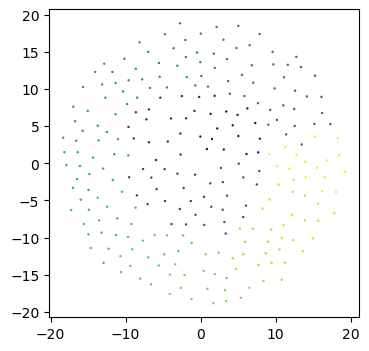

In [9]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.scatter(antx.si, anty.si, s=2, c=antz.si.value, marker='.', cmap='viridis')

## Visualise the gridding for different channels 

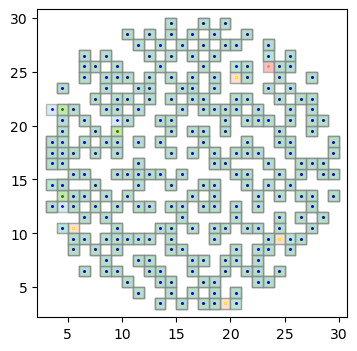

In [10]:
colors = ['coral', 'yellow', 'green', 'blue']
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111)
fccolors = []
boxes = []
for chan in range(4):
    xcorn = xcornerNN[:,chan]
    ycorn = ycornerNN[:,chan]
    xlen = xsizeNN[:,chan]
    ylen = ysizeNN[:,chan]
    ax.plot(xcorn+xlen/2, ycorn+ylen/2, marker='.', ms=2, color=colors[chan], ls='none')
    boxes += [Rectangle((xcorn[i],ycorn[i]), xlen[i], ylen[i]) for i in range(xcorn.size)]
    fccolors += ['light'+colors[chan]]*xcorn.size
pc = PatchCollection(boxes, facecolor=fccolors, edgecolor='gray', alpha=0.5)
ax.add_collection(pc)


## Load the antenna weights with channel and grid position information

In [11]:
with open(datadir+'epic-test-ant-wts-{0:0d}x{1:0d}-grid-{2:0d}-ants-{3:0d}-chans.pkl'.format(ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan), 'rb') as fobj:
    ant_grid_wts_lol = pickle.load(fobj)

## Do some reorganisation of the grid indices

In [12]:
ix_list = []
unraveled_ind_lol = []
raveled_ind_lol = []
delX = (NP.zeros((nants,1))+sizex_ant/wl.reshape(1,-1)).ravel()
delY = (NP.zeros((nants,1))+sizey_ant/wl.reshape(1,-1)).ravel()
for iwl in range(wl.size):    
    ix_ = rect2DNN_to_ix_(ycornerNN[:,iwl], xcornerNN[:,iwl], ysizeNN[:,iwl], xsizeNN[:,iwl])
    ix_list += [copy.deepcopy(ix_)]
    unraveled_ind = ix_to_unraveled_ind(ix_)
    unraveled_ind_lol += [copy.deepcopy(unraveled_ind)]
    raveled_ind = unraveled_to_raveled(unraveled_ind, ant_ugrid.shape)
    raveled_ind_lol += [copy.deepcopy(raveled_ind)]

## Organise the gridded E-field data into channels

In [13]:
grid_Ef_list = []
for iwl in range(wl.size):    
    ant_grid_wts_chan = NP.array(ant_grid_wts_lol[iwl]) # (nant,npol,npol,npix)
    grid_Ef = NP.einsum('ijkl,hik->hijl', NP.array(ant_grid_wts_chan), ant_Etafp[...,iwl,:]) # (nant,npol,npol,npix).(nruns,nant,npol) --> (nruns,nant,npol,npix)
    grid_Ef_list += [NP.copy(grid_Ef)]

## Synthesise gridded weights and gridded E-fields dynamic spectra

In [14]:
grid_wts_cube = gen_ant_grid_wts_cube(ant_ugrid.size, raveled_ind_lol, ant_grid_wts_lol)
grid_E_dynspec = gen_grid_Ef_cube(ant_ugrid.size, raveled_ind_lol, grid_Ef_list)
grid_wts_cube = grid_wts_cube.reshape((grid_wts_cube.shape[:-1]+ant_ugrid.shape))
grid_E_dynspec = grid_E_dynspec.reshape((grid_E_dynspec.shape[:-1]+ant_ugrid.shape))

In [15]:
print(grid_E_dynspec.shape) # (nruns,nchan,npol,nimy,nimx)

(10000, 10, 2, 32, 32)


## output image shape to be twice on each side of the antenna grid (optional padding but useful to avoid aliasing)

In [16]:
imshape = (2*ant_ugrid.shape[0], 2*ant_ugrid.shape[1])
print(imshape) # (nimy,nimx)

(64, 64)


## Generate dynamic spectrum image (including auto-correlations)

In [17]:
img_cube_AC = gen_image(grid_E_dynspec, fftshape=imshape, fftaxes=(-2,-1), polaxis=-3, freqaxis=-4, bwsyn=False)

## Perform synthesis (averaging) along time axis

In [18]:
tsyn_img_cube_AC = NP.mean(img_cube_AC, axis=(0,1), keepdims=True)

In [19]:
print(img_cube_AC.shape) # (nruns,nchan,npol,npol,nimy,nimx)
print(tsyn_img_cube_AC.shape) # (1,1,npol,npol,nimy,nimx)

(10000, 10, 2, 2, 64, 64)
(1, 1, 2, 2, 64, 64)


## Plot grid weights visualised by layers of frequency channels

Text(0.5, 0, '$\\nu$ [MHz]')

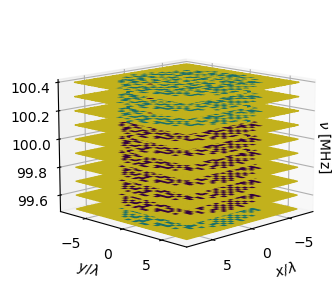

In [20]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
for chan in range(nchan):
    colors = grid_wts_cube[chan,0,0,:,:].real
    cmin = colors.min()
    cmax = colors.max()
    norm = MPL.colors.Normalize(vmin=cmin, vmax=cmax)
    m = PLT.cm.ScalarMappable(cmap='viridis_r')
    # m.set_array([])
    fcolors = m.to_rgba(colors)
    ax.plot_surface(ant_ugrid, ant_vgrid, freqs[chan]+NP.zeros(ant_ugrid.shape), cstride=1, rstride=1, facecolors=fcolors, vmin=colors.min(), vmax=colors.max())
ax.view_init(elev=12.5, azim=45, roll=0)
fig.subplots_adjust(left=0.25, right=0.95, bottom=0.1, top=0.95)
ax.set_xlabel(r'$x/\lambda$')
ax.set_ylabel(r'$y/\lambda$')
ax.set_zlabel(r'$\nu$ [MHz]', labelpad=-130, rotation=180)

## Visualise image dynamic spectra along layers of frequency channels (including auto-correlations)

Text(0.5, 0, '$\\nu$ [MHz]')

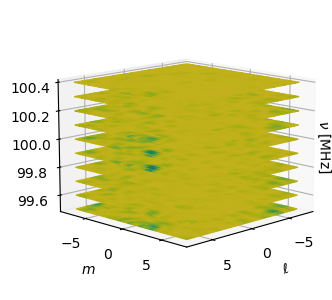

In [21]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
for chan in range(nchan):
    colors = img_cube_AC[0,chan,0,0,:,:].real
    cmin = colors.min()
    cmax = colors.max()
    norm = MPL.colors.Normalize(vmin=cmin, vmax=cmax)
    m = PLT.cm.ScalarMappable(cmap='viridis_r')
    fcolors = m.to_rgba(colors)
    ax.plot_surface(ant_ugrid, ant_vgrid, freqs[chan]+NP.zeros(ant_ugrid.shape)*U.Hz, cstride=1, rstride=1, facecolors=fcolors, vmin=colors.min(), vmax=colors.max())
ax.view_init(elev=12.5, azim=45, roll=0)
fig.subplots_adjust(left=0.25, right=0.95, bottom=0.1, top=0.95)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$m$')
ax.set_zlabel(r'$\nu$ [MHz]', labelpad=-130, rotation=180)

## Visualise time-averaged image of a single channel (includes auto-correlations)

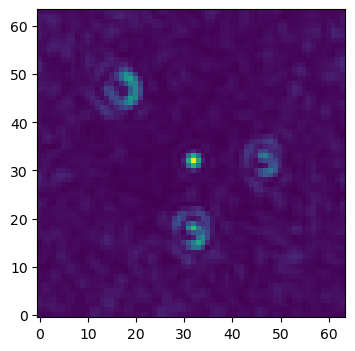

In [22]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(tsyn_img_cube_AC[0,0,0,0,:,:].real, origin='lower', interpolation='none')

## Visualise image time frames (including auto-correlations)

Text(0.5, 0, '$t$ [ms]')

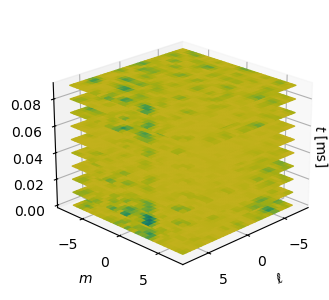

In [28]:
tind = NP.arange(10)
ichan = 0
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
for ti in tind:
    colors = img_cube_AC[ti,0,0,0,:,:].real
    cmin = colors.min()
    cmax = colors.max()
    norm = MPL.colors.Normalize(vmin=cmin, vmax=cmax)
    m = PLT.cm.ScalarMappable(cmap='viridis_r')
    fcolors = m.to_rgba(colors)
    ax.plot_surface(ant_ugrid, ant_vgrid, times[ti].to('ms')*NP.ones(ant_ugrid.shape), cstride=1, rstride=1, facecolors=fcolors, vmin=colors.min(), vmax=colors.max())
ax.view_init(elev=22.5, azim=45, roll=0)
fig.subplots_adjust(left=0.25, right=0.95, bottom=0.1, top=0.95)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$m$')
ax.set_zlabel(r'$t$ [ms]', labelpad=-130, rotation=180)

In [25]:
print(times)

[0.000e+00 1.000e-05 2.000e-05 ... 9.997e-02 9.998e-02 9.999e-02] s
